# Задание 2.0

## Подключаем нужные библиотеки

In [81]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

## Загружаем Dataset

In [82]:
df = pd.read_csv("d:/loan_train.csv")
df = df.dropna()
df.head()

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,Male,No,0,Graduate,No,584900,0.0,15000000,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,458300,150800.0,12800000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,300000,0.0,6600000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,258300,235800.0,12000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,600000,0.0,14100000,360.0,1.0,Urban,Y


In [83]:
le = LabelEncoder()
df_encode= df.copy()
for i, f in enumerate(df.select_dtypes(include="object")):
    le.fit(df_encode[f])  
    df_encode[f] = le.fit_transform(df_encode[f])

In [84]:
df_encode.head()

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,1,0,0,0,0,584900,0.0,15000000,360.0,1.0,2,1
1,1,1,1,0,0,458300,150800.0,12800000,360.0,1.0,0,0
2,1,1,0,0,1,300000,0.0,6600000,360.0,1.0,2,1
3,1,1,0,1,0,258300,235800.0,12000000,360.0,1.0,2,1
4,1,0,0,0,0,600000,0.0,14100000,360.0,1.0,2,1


In [85]:
X, y = df_encode.drop(columns='Status'), df_encode["Status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, test_size=0.25)

<Axes: ylabel='Density'>

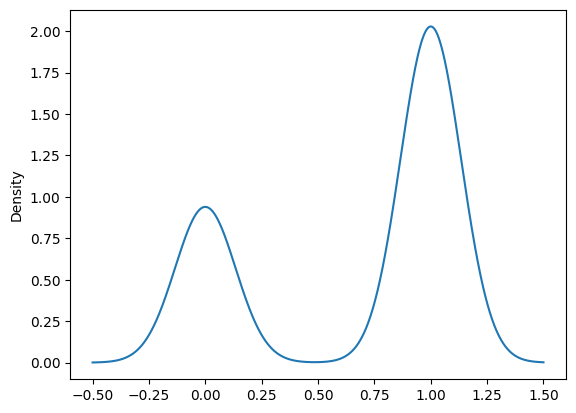

In [86]:
y.plot(kind='kde')

              precision    recall  f1-score   support

           0       0.92      0.29      0.44        38
           1       0.76      0.99      0.86        87

    accuracy                           0.78       125
   macro avg       0.84      0.64      0.65       125
weighted avg       0.81      0.78      0.73       125



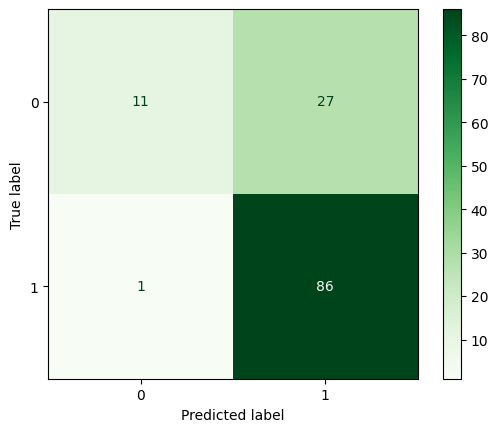

In [87]:
lg = LogisticRegression()
lg.fit(X_train, y_train)
y_preds_lg = lg.predict(X_test)
print(classification_report(y_test, y_preds_lg))
ConfusionMatrixDisplay(confusion_matrix(y_test,y_preds_lg)).plot(cmap='Greens')

In [88]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        # ("clf", LogisticRegression()),
        (KNeighborsClassifier())
    ]
)

In [89]:
model = pipeline.fit(X_train, y_train)
y_pred_simple = model.predict(X_test)
print(classification_report(y_test, y_pred_simple))

              precision    recall  f1-score   support

           0       1.00      0.32      0.48        38
           1       0.77      1.00      0.87        87

    accuracy                           0.79       125
   macro avg       0.88      0.66      0.68       125
weighted avg       0.84      0.79      0.75       125



In [116]:
parameters = {
    'scaler__with_mean': [True, False],
    'clf__C': np.linspace(0.01, 1, 10),
    'clf__penalty': ['l2', 'none'],
    'clf__random_state': [2023],
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    n_jobs=5,
    verbose=10,
)

In [117]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', LogisticRegression())]),
             n_jobs=5,
             param_grid={'clf__C': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                         'clf__penalty': ['l2', 'none'],
                         'clf__random_state': [2023],
                         'scaler__with_mean': [True, False]},
             verbose=10)

In [118]:
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

clf__C: 0.12
clf__penalty: l2
clf__random_state: 2023
scaler__with_mean: True


In [119]:
y_pred_optimized = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_optimized))

              precision    recall  f1-score   support

           0       1.00      0.32      0.48        38
           1       0.77      1.00      0.87        87

    accuracy                           0.79       125
   macro avg       0.88      0.66      0.68       125
weighted avg       0.84      0.79      0.75       125



In [120]:
from sklearn.model_selection import RandomizedSearchCV

In [125]:
parameters = {
    'scaler__with_mean': [True, False],
    'clf__C': np.linspace(0.01, 10, 10),
    'clf__penalty': ['l2', 'none'],
    'clf__random_state': [2023],
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameters,
    n_iter=30,
    random_state=2023,
    n_jobs=5,
    verbose=1,
)

In [126]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('clf', LogisticRegression())]),
                   n_iter=30, n_jobs=5,
                   param_distributions={'clf__C': array([ 0.01,  1.12,  2.23,  3.34,  4.45,  5.56,  6.67,  7.78,  8.89,
       10.  ]),
                                        'clf__penalty': ['l2', 'none'],
                                        'clf__random_state': [2023],
                                        'scaler__with_mean': [True, False]},
                   random_state=2023, verbose=1)

In [127]:
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

clf__C: 10.0
clf__penalty: l2
clf__random_state: 2023
scaler__with_mean: False


In [128]:
y_pred_optimized = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_optimized))

              precision    recall  f1-score   support

           0       1.00      0.32      0.48        38
           1       0.77      1.00      0.87        87

    accuracy                           0.79       125
   macro avg       0.88      0.66      0.68       125
weighted avg       0.84      0.79      0.75       125



In [ ]:
import optuna

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

In [ ]:
def objective(trial):
    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForest"])
    if classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
        classifier_obj = SVC(C=svc_c, gamma="auto")
    else:
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        classifier_obj = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=10)

    score = cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

[I 2024-02-28 17:23:53,086] A new study created in memory with name: no-name-97068d2b-0f14-4c84-98cd-24b19d4e4a71
[I 2024-02-28 17:23:53,112] Trial 0 finished with value: 0.6873842676093597 and parameters: {'classifier': 'SVC', 'svc_c': 370.30553043488726}. Best is trial 0 with value: 0.6873842676093597.
[I 2024-02-28 17:23:53,137] Trial 1 finished with value: 0.6873842676093597 and parameters: {'classifier': 'SVC', 'svc_c': 2.694388487326042}. Best is trial 0 with value: 0.6873842676093597.
[I 2024-02-28 17:23:53,162] Trial 2 finished with value: 0.6833682033523315 and parameters: {'classifier': 'SVC', 'svc_c': 1.4170429918952242e-09}. Best is trial 0 with value: 0.6873842676093597.
[I 2024-02-28 17:23:53,187] Trial 3 finished with value: 0.6833682033523315 and parameters: {'classifier': 'SVC', 'svc_c': 0.0004963232549918617}. Best is trial 0 with value: 0.6873842676093597.
[I 2024-02-28 17:23:53,212] Trial 4 finished with value: 0.6833682033523315 and parameters: {'classifier': 'SVC'

In [121]:
print(classification_report(y_test, y_pred_optimized))

              precision    recall  f1-score   support

           0       1.00      0.32      0.48        38
           1       0.77      1.00      0.87        87

    accuracy                           0.79       125
   macro avg       0.88      0.66      0.68       125
weighted avg       0.84      0.79      0.75       125

